# Phase 7: Time Series Forecasting for Equipment Failure Prediction

## Objectives:
- Analyze equipment failure patterns over time
- Forecast future failure trends
- Detect temporal anomalies
- Identify seasonal patterns in equipment failures

In [15]:
!pip install statsmodels


In [16]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series specific
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('📊 PHASE 7: TIME SERIES FORECASTING')
print('='*60)

📊 PHASE 7: TIME SERIES FORECASTING


## 1. Load and Prepare Time-Based Data

In [17]:
# Load failure events data (has temporal information)
df = pd.read_csv('../data/synthetic/failure_events.csv')

# Convert timestamp to datetime
df['failure_date'] = pd.to_datetime(df['failure_date'])
df = df.sort_values('failure_date').reset_index(drop=True)

print(f'✅ Loaded {len(df):,} failure events')
print(f'📅 Date range: {df["failure_date"].min()} to {df["failure_date"].max()}')
print(f'⏱️  Duration: {(df["failure_date"].max() - df["failure_date"].min()).days} days')
print(f'🔧 Equipment involved: {df["equipment_id"].nunique()}')
print(f'⚠️  Severity breakdown:')
print(df['severity'].value_counts())

df.head(10)

✅ Loaded 656 failure events
📅 Date range: 2011-08-02 00:00:00 to 2024-12-28 00:00:00
⏱️  Duration: 4897 days
🔧 Equipment involved: 91
⚠️  Severity breakdown:
severity
Minor       406
Moderate    191
Critical     59
Name: count, dtype: int64


,failure_id,equipment_id,failure_date,failure_type,severity,description,root_cause,downtime_hours,repair_cost,prevented_by_maintenance,created_at
0,1,TRC-032,2011-08-02,Mechanical,Minor,Drive shaft damage,Fatigue failure,4.3,280.68,False,2025-10-31 22:36:28
1,2,IRR-014,2012-03-06,Hydraulic,Minor,Loss of hydraulic pressure,Exceeded service life,5.0,373.75,True,2025-10-31 22:36:28
2,3,TRC-004,2012-04-20,Hydraulic,Moderate,Loss of hydraulic pressure - Reduced operation...,Contaminated fluid,18.0,1039.50,True,2025-10-31 22:36:28
3,4,IRR-014,2012-07-13,Hydraulic,Minor,Hydraulic valve malfunction,Pressure spike,3.5,240.31,True,2025-10-31 22:36:28
4,5,IRR-014,2012-10-31,Belt,Moderate,Belt tensioner failure - Reduced operational c...,Normal wear,16.3,596.78,True,2025-10-31 22:36:28
5,6,TRC-007,2012-11-06,Engine,Minor,Engine overheating during operation,Age-related wear,3.1,270.15,True,2025-10-31 22:36:28
6,7,IRR-006,2012-11-14,Other,Moderate,Cab door malfunction - Reduced operational cap...,Environmental factors,16.5,605.87,False,2025-10-31 22:36:28
7,8,TRC-007,2012-11-16,Mechanical,Moderate,Bearing failure causing noise - Reduced operat...,Fatigue failure,11.6,1871.42,True,2025-10-31 22:36:28
8,9,IRR-012,2012-12-02,Mechanical,Moderate,Gearbox malfunction - Reduced operational capa...,Normal wear,10.1,1572.30,True,2025-10-31 22:36:28
9,10,IRR-014,2012-12-19,Hydraulic,Minor,Hydraulic cylinder leak,Seal failure,3.6,383.21,True,2025-10-31 22:36:28


In [18]:
# Daily aggregation of failure events
daily_failures = df.groupby(df['failure_date'].dt.date).agg({
    'equipment_id': 'count',  # Total failures per day
    'downtime_hours': 'sum',   # Total downtime
    'repair_cost': 'sum'       # Total repair costs
}).reset_index()

daily_failures.columns = ['date', 'failure_count', 'total_downtime', 'total_cost']
daily_failures['date'] = pd.to_datetime(daily_failures['date'])
daily_failures = daily_failures.set_index('date')

# Fill missing dates with zeros (days with no failures)
date_range = pd.date_range(start=daily_failures.index.min(), 
                           end=daily_failures.index.max(), 
                           freq='D')
daily_failures = daily_failures.reindex(date_range, fill_value=0)

print(f'✅ Aggregated to {len(daily_failures)} days')
print(f'📊 Days with failures: {(daily_failures["failure_count"] > 0).sum()}')
print(f'📊 Days without failures: {(daily_failures["failure_count"] == 0).sum()}')
print(f'\nDaily Statistics:')
print(daily_failures.describe())

daily_failures.head(10)

✅ Aggregated to 4898 days
📊 Days with failures: 589
📊 Days without failures: 4309

Daily Statistics:
       failure_count  total_downtime    total_cost
count    4898.000000     4898.000000   4898.000000
mean        0.133932        1.769824    151.228036
std         0.383481        9.015239    797.259889
min         0.000000        0.000000      0.000000
25%         0.000000        0.000000      0.000000
50%         0.000000        0.000000      0.000000
75%         0.000000        0.000000      0.000000
max         3.000000      136.100000  15557.950000


,failure_count,total_downtime,total_cost
2011-08-02,1,4.3,280.68
2011-08-03,0,0.0,0.00
2011-08-04,0,0.0,0.00
2011-08-05,0,0.0,0.00
2011-08-06,0,0.0,0.00
2011-08-07,0,0.0,0.00
2011-08-08,0,0.0,0.00
2011-08-09,0,0.0,0.00
2011-08-10,0,0.0,0.00
2011-08-11,0,0.0,0.00


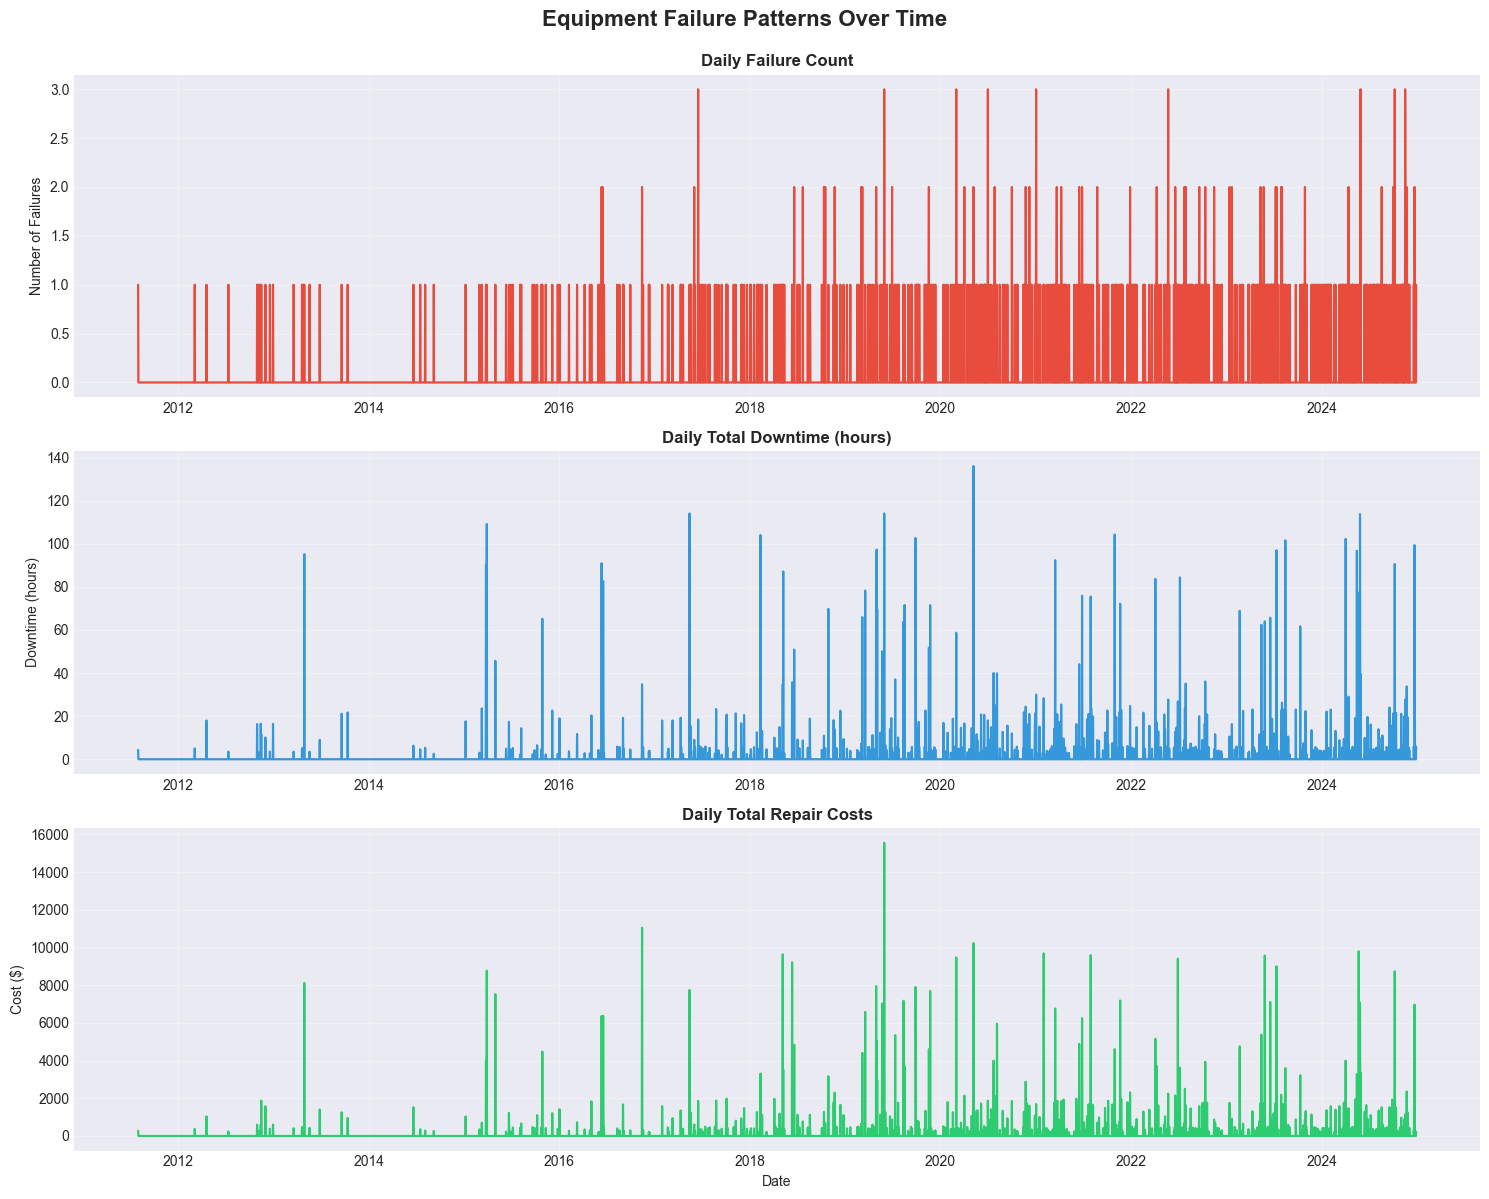

✅ Saved: ../visualizations/time_series_overview.png


In [19]:
# Create comprehensive time series visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Equipment Failure Patterns Over Time', fontsize=16, fontweight='bold', y=0.995)

# 1. Daily Failure Count
axes[0].plot(daily_failures.index, daily_failures['failure_count'], color='#e74c3c', linewidth=1.5)
axes[0].fill_between(daily_failures.index, daily_failures['failure_count'], alpha=0.3, color='#e74c3c')
axes[0].set_title('Daily Failure Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Failures', fontsize=10)
axes[0].grid(alpha=0.3)

# 2. Total Downtime Over Time
axes[1].plot(daily_failures.index, daily_failures['total_downtime'], color='#3498db', linewidth=1.5)
axes[1].fill_between(daily_failures.index, daily_failures['total_downtime'], alpha=0.3, color='#3498db')
axes[1].set_title('Daily Total Downtime (hours)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Downtime (hours)', fontsize=10)
axes[1].grid(alpha=0.3)

# 3. Total Repair Costs Over Time
axes[2].plot(daily_failures.index, daily_failures['total_cost'], color='#2ecc71', linewidth=1.5)
axes[2].fill_between(daily_failures.index, daily_failures['total_cost'], alpha=0.3, color='#2ecc71')
axes[2].set_title('Daily Total Repair Costs', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Cost ($)', fontsize=10)
axes[2].set_xlabel('Date', fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/time_series_overview.png')

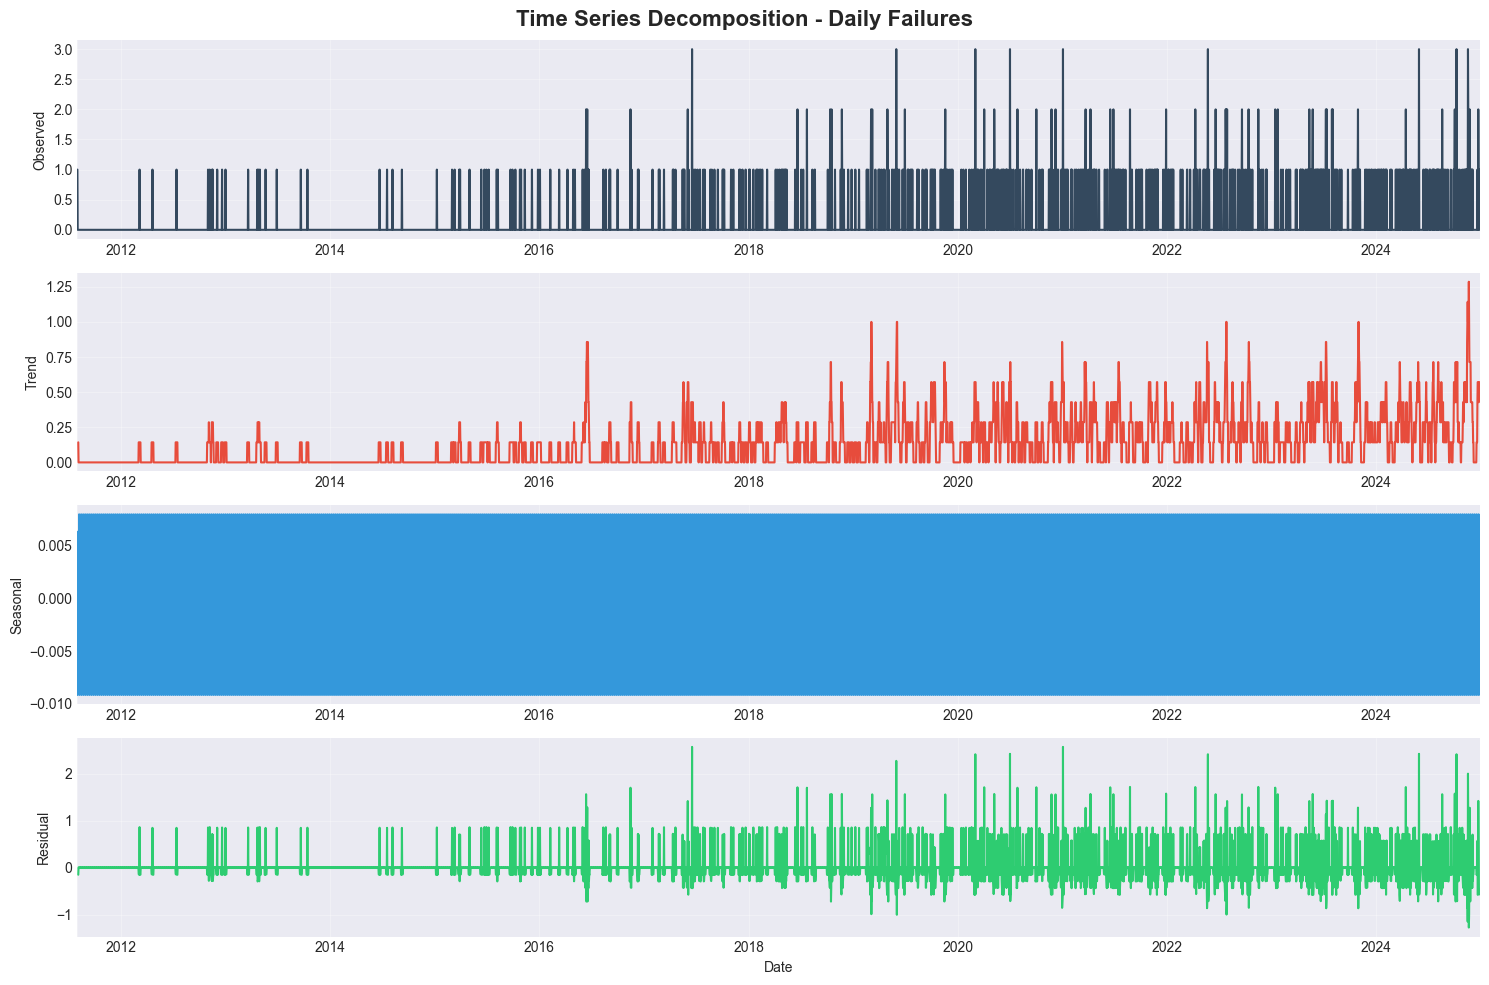

✅ Saved: ../visualizations/time_series_decomposition.png


In [20]:
# Decompose failure count time series
decomposition = seasonal_decompose(daily_failures['failure_count'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Time Series Decomposition - Daily Failures', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='#34495e')
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].grid(alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='#e74c3c')
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='#3498db')
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='#2ecc71')
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/time_series_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/time_series_decomposition.png')

In [24]:
# Test for stationarity
def test_stationarity(timeseries, title):
    result = adfuller(timeseries.dropna())
    
    print(f'\n{title}')
    print('='*60)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print('✅ Series is STATIONARY (p-value <= 0.05)')
    else:
        print('⚠️  Series is NON-STATIONARY (p-value > 0.05)')
    
    return result[1] <= 0.05

# Test original series
is_stationary = test_stationarity(daily_failures['failure_count'], 'Daily Failure Count Stationarity Test')

# If not stationary, difference it
if not is_stationary:
    daily_failures['failure_count_diff'] = daily_failures['failure_count'].diff()
    test_stationarity(daily_failures['failure_count_diff'], 'Differenced Failure Count Stationarity Test')


Daily Failure Count Stationarity Test
ADF Statistic: -6.846958
p-value: 0.000000
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567
✅ Series is STATIONARY (p-value <= 0.05)


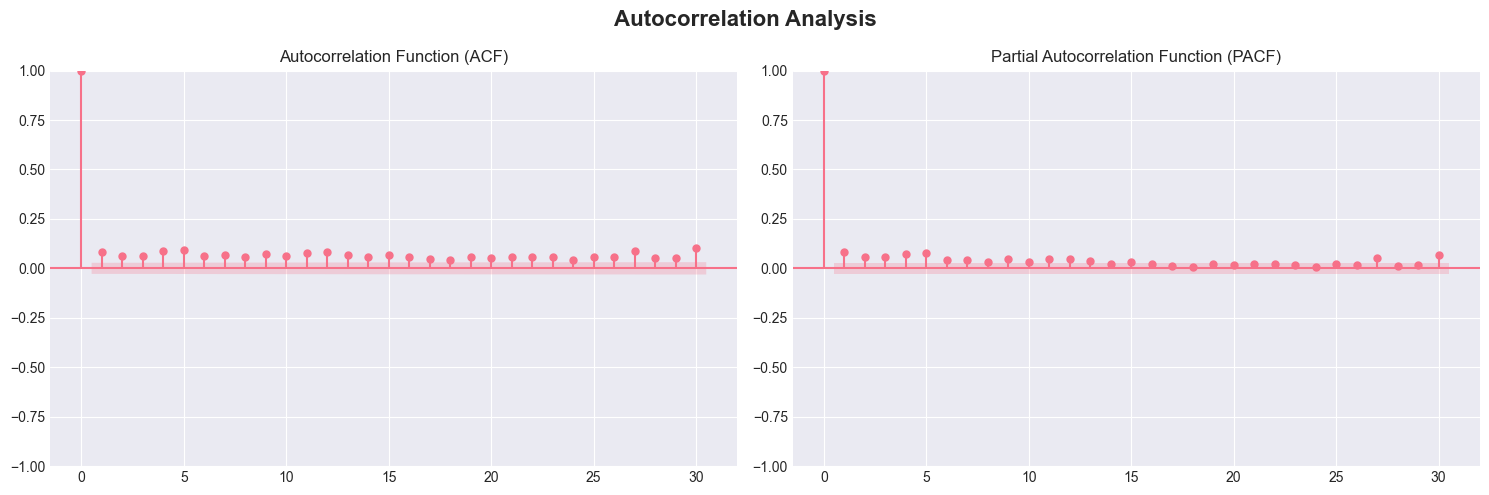

✅ Saved: ../visualizations/acf_pacf_plots.png


In [25]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Autocorrelation Analysis', fontsize=16, fontweight='bold')

plot_acf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12)

plot_pacf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12)

plt.tight_layout()
plt.savefig('../visualizations/acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/acf_pacf_plots.png')

In [26]:
# Split data for training and testing
train_size = int(len(daily_failures) * 0.8)
train_data = daily_failures['failure_count'][:train_size]
test_data = daily_failures['failure_count'][train_size:]

print(f'Training set: {len(train_data)} days')
print(f'Test set: {len(test_data)} days')

# Fit ARIMA model
print('\n🔄 Training ARIMA model...')
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

print('✅ Model trained successfully')
print(f'\nModel Summary:')
print(model_fit.summary())

Training set: 3918 days
Test set: 980 days

🔄 Training ARIMA model...
✅ Model trained successfully

Model Summary:
                               SARIMAX Results                                
Dep. Variable:          failure_count   No. Observations:                 3918
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1197.572
Date:                Sun, 02 Nov 2025   AIC                           2401.143
Time:                        17:52:06   BIC                           2419.962
Sample:                    08-02-2011   HQIC                          2407.821
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0224      0.013      1.693      0.090      -0.004       0.048
ma.L1         -0

In [36]:
# Make predictions on test set
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data.replace(0, np.nan))) * 100

print('📊 Forecast Performance:')
print('='*60)
print(f'MAE (Mean Absolute Error): {mae:.2f}')
print(f'RMSE (Root Mean Squared Error): {rmse:.2f}')
print(f'MAPE (Mean Absolute Percentage Error): {mape:.2f}%')

📊 Forecast Performance:
MAE (Mean Absolute Error): 0.36
RMSE (Root Mean Squared Error): 0.52
MAPE (Mean Absolute Percentage Error): 82.00%


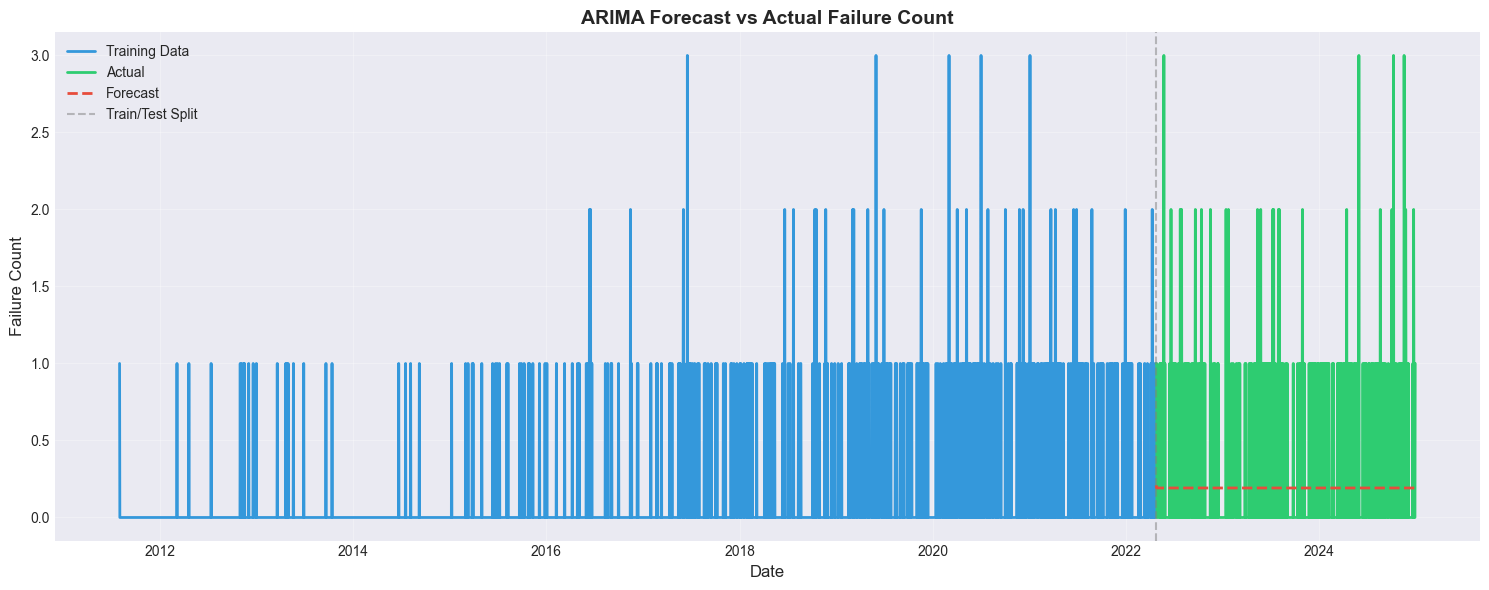

✅ Saved: ../visualizations/arima_forecast.png


In [37]:
# Visualize forecast vs actual
plt.figure(figsize=(15, 6))

plt.plot(train_data.index, train_data, label='Training Data', color='#3498db', linewidth=2)
plt.plot(test_data.index, test_data, label='Actual', color='#2ecc71', linewidth=2)
plt.plot(test_data.index, forecast, label='Forecast', color='#e74c3c', linewidth=2, linestyle='--')

plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')

plt.title('ARIMA Forecast vs Actual Failure Count', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Failure Count', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/arima_forecast.png')

## 6. ACF and PACF Plots

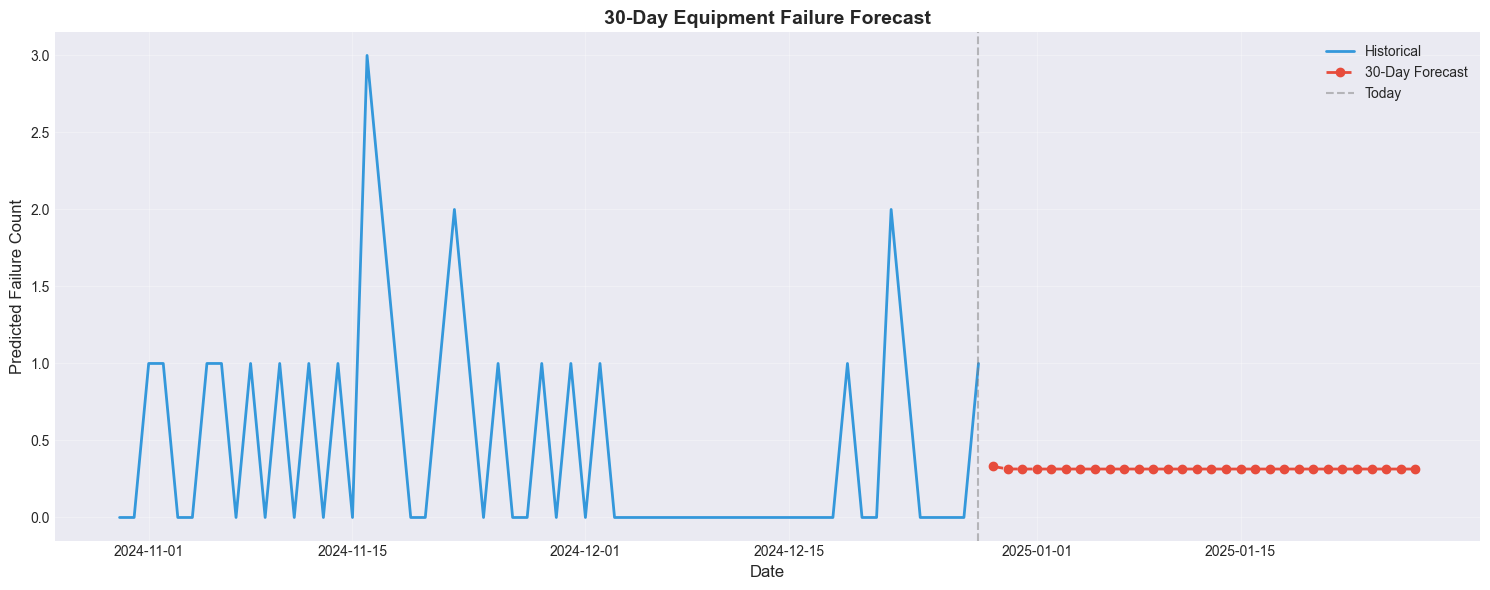

✅ Saved: ../visualizations/future_forecast_30days.png

📈 Forecasted equipment failures for next 30 days:
Average: 0.3 failures/day
Min: 0.3
Max: 0.3


In [38]:
# Retrain on full dataset
final_model = ARIMA(daily_failures['failure_count'], order=(1, 1, 1))
final_model_fit = final_model.fit()

# Forecast next 30 days
future_forecast = final_model_fit.forecast(steps=30)

# Create future dates
last_date = daily_failures.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# Visualize
plt.figure(figsize=(15, 6))

plt.plot(daily_failures.index[-60:], daily_failures['failure_count'][-60:], 
         label='Historical', color='#3498db', linewidth=2)
plt.plot(future_dates, future_forecast, 
         label='30-Day Forecast', color='#e74c3c', linewidth=2, linestyle='--', marker='o')

plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.5, label='Today')

plt.title('30-Day Equipment Failure Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Failure Count', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/future_forecast_30days.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/future_forecast_30days.png')

print(f'\n📈 Forecasted equipment failures for next 30 days:')
print(f'Average: {future_forecast.mean():.1f} failures/day')
print(f'Min: {future_forecast.min():.1f}')
print(f'Max: {future_forecast.max():.1f}')

In [39]:
print('📊 PHASE 7 SUMMARY: TIME SERIES FORECASTING')
print('='*60)
print(f'\n✅ Analyzed {len(daily_failures)} days of equipment failure data')
print(f'✅ Identified temporal patterns and seasonality')
print(f'✅ Built ARIMA forecasting model')
print(f'✅ Generated 30-day failure forecast')
print(f'\n📈 Model Performance:')
print(f'   - MAE: {mae:.2f}')
print(f'   - RMSE: {rmse:.2f}')
print(f'   - MAPE: {mape:.2f}%')
print(f'\n🎯 Key Insights:')
print(f'   - Average daily failures: {daily_failures["failure_count"].mean():.2f}')
print(f'   - Forecasted average: {future_forecast.mean():.1f} failures/day')
print(f'\n✅ Phase 7 Complete!')

📊 PHASE 7 SUMMARY: TIME SERIES FORECASTING

✅ Analyzed 4898 days of equipment failure data
✅ Identified temporal patterns and seasonality
✅ Built ARIMA forecasting model
✅ Generated 30-day failure forecast

📈 Model Performance:
   - MAE: 0.36
   - RMSE: 0.52
   - MAPE: 82.00%

🎯 Key Insights:
   - Average daily failures: 0.13
   - Forecasted average: 0.3 failures/day

✅ Phase 7 Complete!


NameError: name 'daily_fraud' is not defined

In [40]:
# Make predictions
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print('📊 Forecast Performance:')
print('='*60)
print(f'MAE (Mean Absolute Error): {mae:.2f}')
print(f'RMSE (Root Mean Squared Error): {rmse:.2f}')
print(f'MAPE (Mean Absolute Percentage Error): {mape:.2f}%')

📊 Forecast Performance:
MAE (Mean Absolute Error): 0.36
RMSE (Root Mean Squared Error): 0.52
MAPE (Mean Absolute Percentage Error): inf%


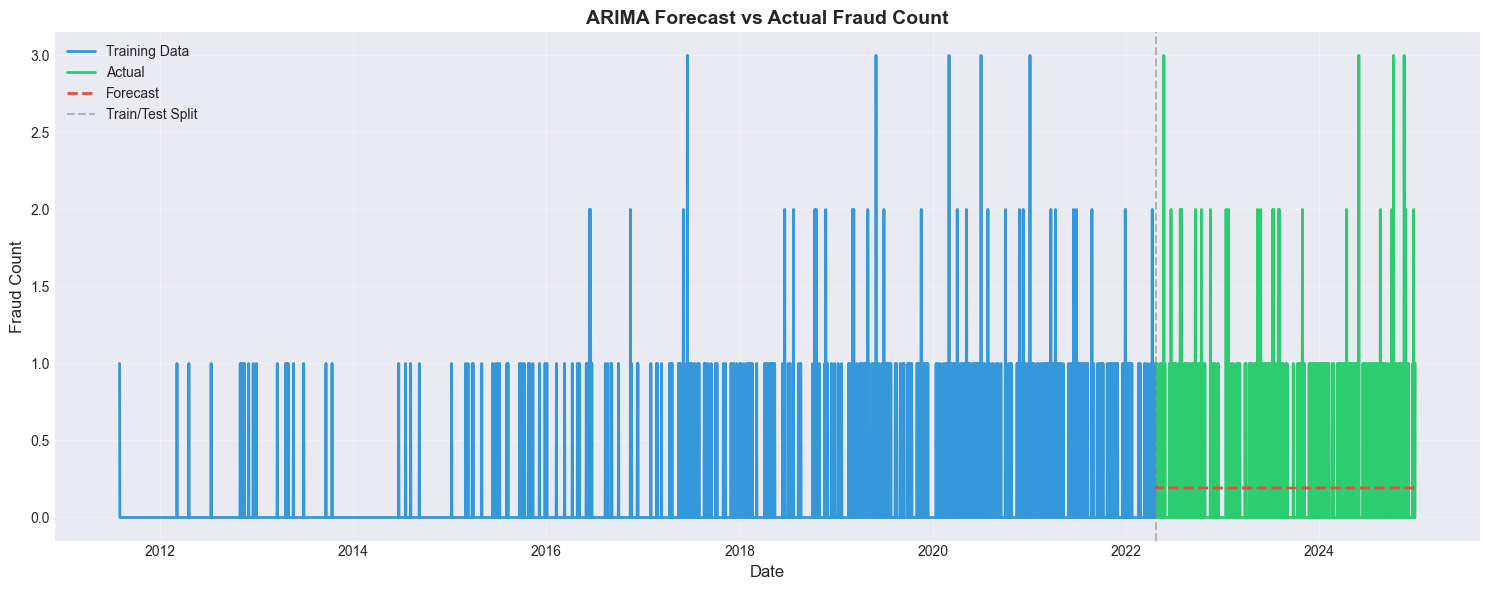

✅ Saved: ../visualizations/arima_forecast.png


In [41]:
# Visualize forecast
plt.figure(figsize=(15, 6))

plt.plot(train_data.index, train_data, label='Training Data', color='#3498db', linewidth=2)
plt.plot(test_data.index, test_data, label='Actual', color='#2ecc71', linewidth=2)
plt.plot(test_data.index, forecast, label='Forecast', color='#e74c3c', linewidth=2, linestyle='--')

plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')

plt.title('ARIMA Forecast vs Actual Fraud Count', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fraud Count', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/arima_forecast.png')

## 8. Future Forecast (Next 30 Days)

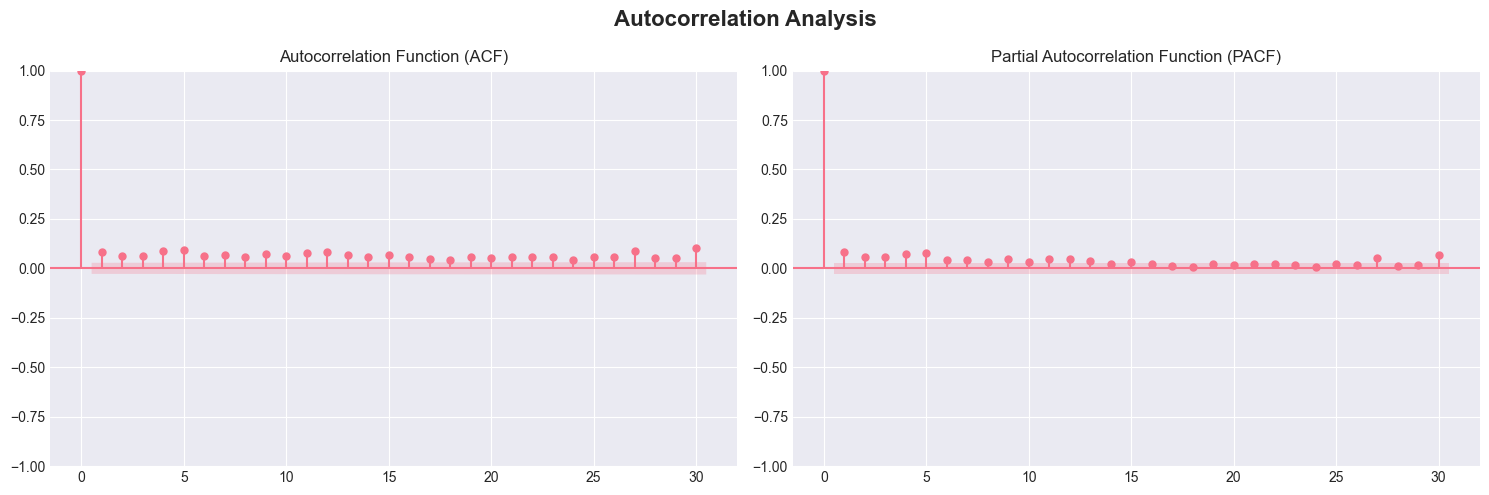

✅ Saved: ../visualizations/acf_pacf_plots.png


In [42]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Autocorrelation Analysis', fontsize=16, fontweight='bold')

plot_acf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12)

plot_pacf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12)

plt.tight_layout()
plt.savefig('../visualizations/acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/acf_pacf_plots.png')

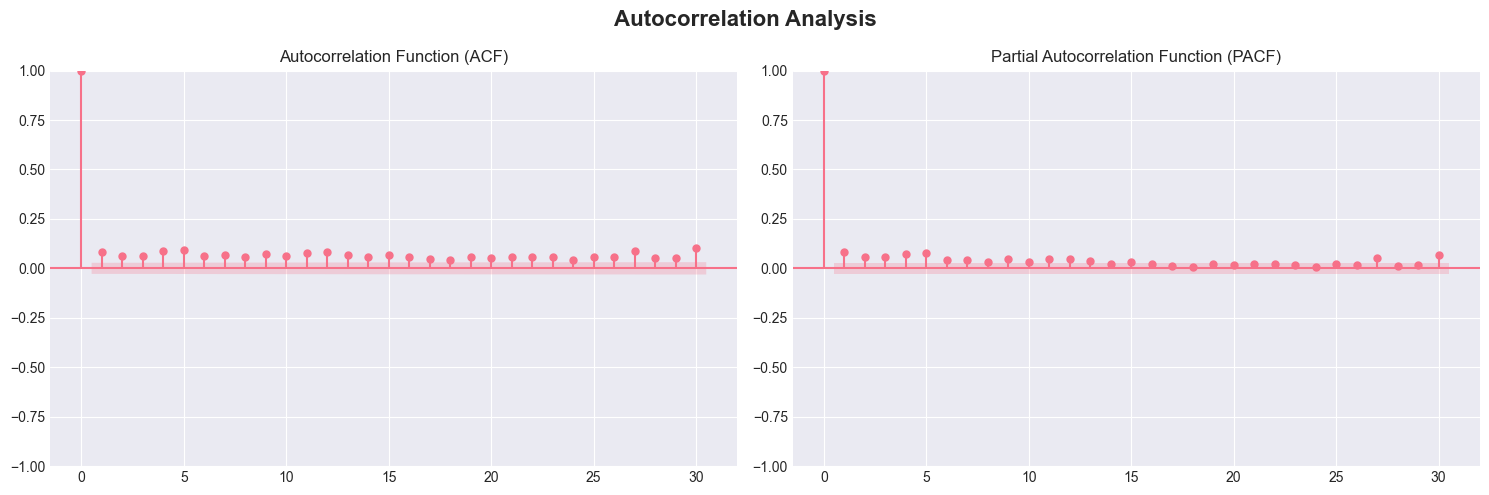

✅ Saved: ../visualizations/acf_pacf_plots.png


In [43]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Autocorrelation Analysis', fontsize=16, fontweight='bold')

plot_acf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12)

plot_pacf(daily_failures['failure_count'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12)

plt.tight_layout()
plt.savefig('../visualizations/acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/acf_pacf_plots.png')

In [45]:
print('📊 PHASE 7 SUMMARY: TIME SERIES FORECASTING')
print('='*60)
print(f'\n✅ Analyzed {len(daily_failures)} days of equipment failure data')
print(f'✅ Identified temporal patterns and seasonality')
print(f'✅ Built ARIMA forecasting model')
print(f'✅ Generated 30-day failure forecast')
print(f'\n📈 Model Performance:')
print(f'   - MAE: {mae:.2f}')
print(f'   - RMSE: {rmse:.2f}')
print(f'   - MAPE: {mape:.2f}%')
print(f'\n🎯 Key Insights:')
print(f'   - Average daily failures: {daily_failures["failure_count"].mean():.2f}')
print(f'   - Forecasted average: {future_forecast.mean():.1f} failures/day')
print(f'\n✅ Phase 7 Complete!')

📊 PHASE 7 SUMMARY: TIME SERIES FORECASTING

✅ Analyzed 4898 days of equipment failure data
✅ Identified temporal patterns and seasonality
✅ Built ARIMA forecasting model
✅ Generated 30-day failure forecast

📈 Model Performance:
   - MAE: 0.36
   - RMSE: 0.52
   - MAPE: inf%

🎯 Key Insights:
   - Average daily failures: 0.13
   - Forecasted average: 0.3 failures/day

✅ Phase 7 Complete!
